# Importing Libraries

In [1]:
# %pip install matplotlib, pandas, keras, tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from keras.utils import image_dataset_from_directory, load_img
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Rescaling
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop

# Displaying Images

In [3]:
picture_size = 48
folder_path = "../Ht23-Deep-Learning-Tentamen/images/"

In [4]:
os.listdir(folder_path+"train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

angry


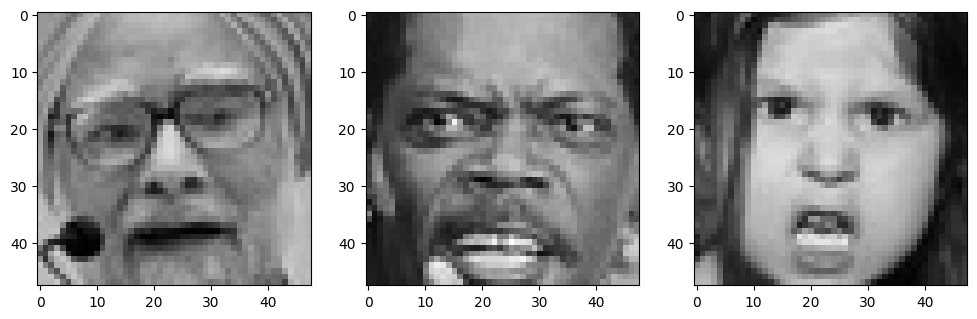

disgust


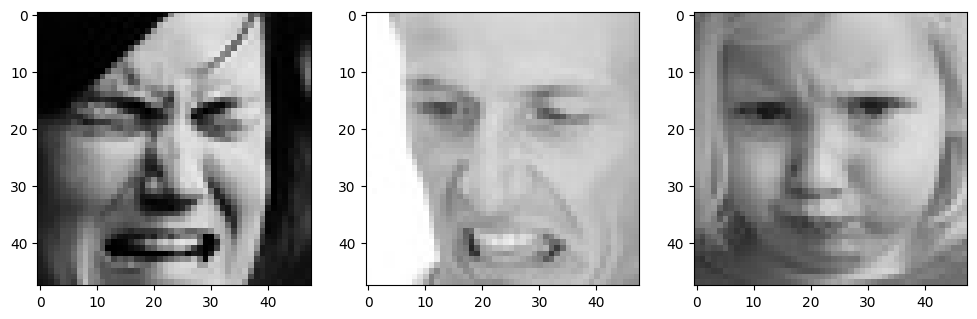

fear


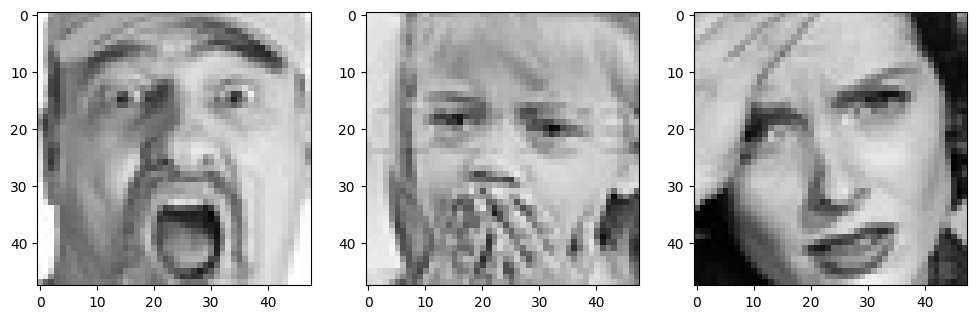

happy


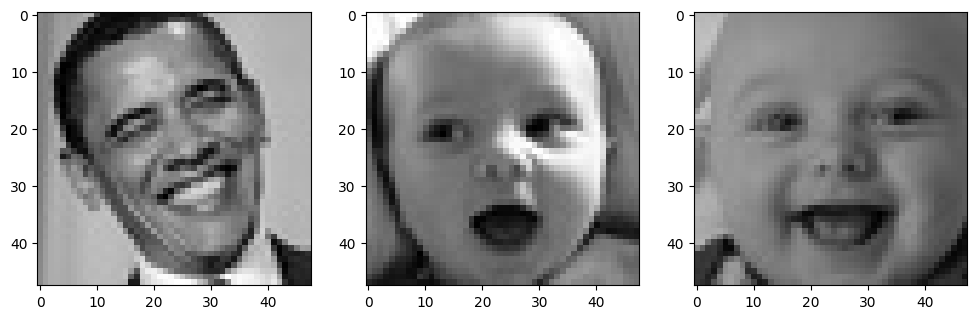

neutral


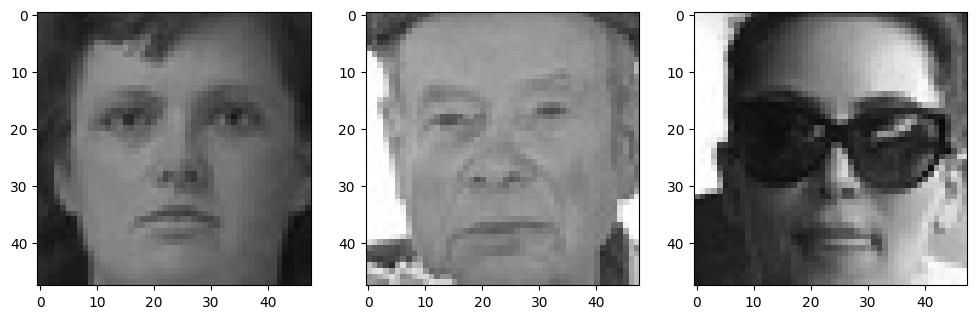

sad


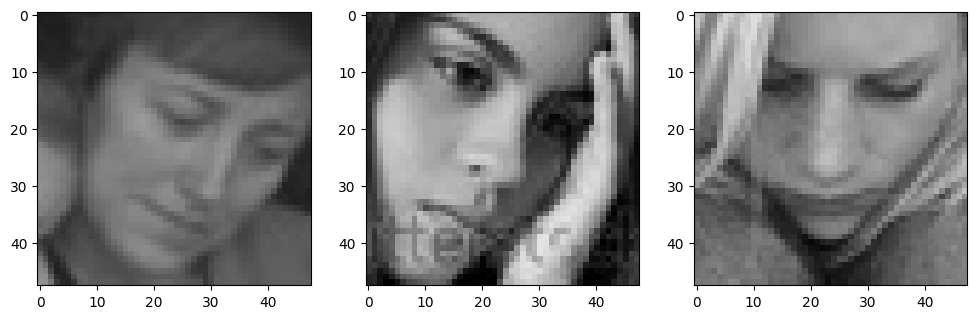

surprise


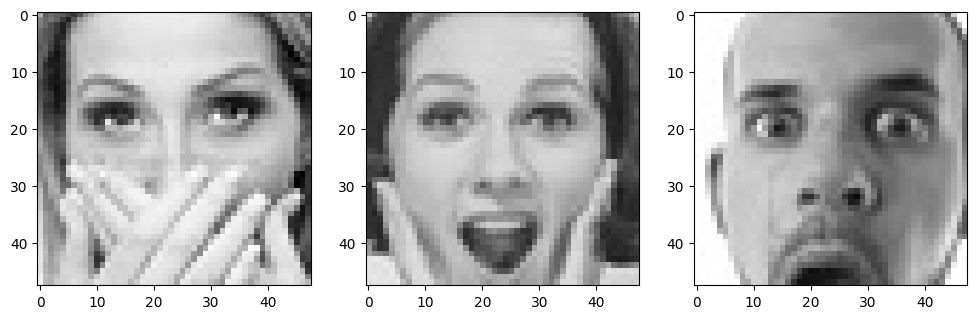

In [5]:
# List of directorys containing all expressions
expression = list(os.listdir(folder_path+"train"))

for exp in expression:
    plt.figure(figsize= (12,12))
    print(exp)
    for i in range(1, 4, 1):
        plt.subplot(1,3,i)
        img = load_img(folder_path+"train/"+exp+"/"+
                       os.listdir(folder_path + "train/" + exp)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()

# Making Training and Validation Data

In [6]:
# batch_size  = 128

# datagen_train  = ImageDataGenerator()
# datagen_val = ImageDataGenerator()

# train_set = datagen_train.flow_from_directory(folder_path+"train",
#                                               target_size = (picture_size,picture_size),
#                                               color_mode = "grayscale",
#                                               batch_size=batch_size,
#                                               class_mode='categorical',
#                                               shuffle=True)


# test_set = datagen_val.flow_from_directory(folder_path+"validation",
#                                               target_size = (picture_size,picture_size),
#                                               color_mode = "grayscale",
#                                               batch_size=batch_size,
#                                               class_mode='categorical',
#                                               shuffle=False)

In [18]:
batch_size  = 32

# tf.keras.utils.image_dataset_from_directory
train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size
    )

val_ds = image_dataset_from_directory(
    folder_path+"validation",
    labels="inferred",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
    )

# Limit datasets to 100 images to speed up training while testing
train_ds = train_ds.take(100)
val_ds = val_ds.take(100)


Found 28823 files belonging to 7 classes.
Using 23059 files for training.
Found 7066 files belonging to 7 classes.


In [8]:
# Normalization layer
normalization_layer = Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.078431375 0.89019614


# Model Building

In [9]:
no_of_classes = 7
input_shape = (picture_size, picture_size, 1)

model = Sequential()

# Rescaling layer doesn't work for some reason
# model.add(Rescaling(scale=1./255))

#1st CNN layer
model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, 5,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

# Fitting the Model with Training and Validation Data 

In [14]:
# from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True
                               )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001
                                        )

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 3

model.compile(loss='SparseCategoricalCrossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy']
              )

In [15]:
# steps_per_epoch and validation_steps commented out due to default values
# "WARNING:tensorflow:Can save best model only with val_acc available, skipping."

history = model.fit(train_ds,
                    # steps_per_epoch=train_ds.n//train_ds.batch_size,
                    epochs=epochs,
                    validation_data = val_ds,
                    # validation_steps = val_ds.n//val_ds.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/3


100/100 [==============================] - ETA: 0s - loss: 2.0124 - accuracy: 0.2481
Epoch 1: val_accuracy improved from -inf to 0.10250, saving model to .\model.h5
100/100 [==============================] - 44s 416ms/step - loss: 2.0124 - accuracy: 0.2481 - val_loss: 2.6750 - val_accuracy: 0.1025 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 1.8110 - accuracy: 0.3187
Epoch 2: val_accuracy improved from 0.10250 to 0.32500, saving model to .\model.h5
100/100 [==============================] - 41s 411ms/step - loss: 1.8110 - accuracy: 0.3187 - val_loss: 1.7298 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 1.7267 - accuracy: 0.3553
Epoch 3: val_accuracy did not improve from 0.32500
100/100 [==============================] - 40s 402ms/step - loss: 1.7267 - accuracy: 0.3553 - val_loss: 1.8306 - val_accuracy: 0.2891 - lr: 0.0010


# Plotting Accuracy & Loss

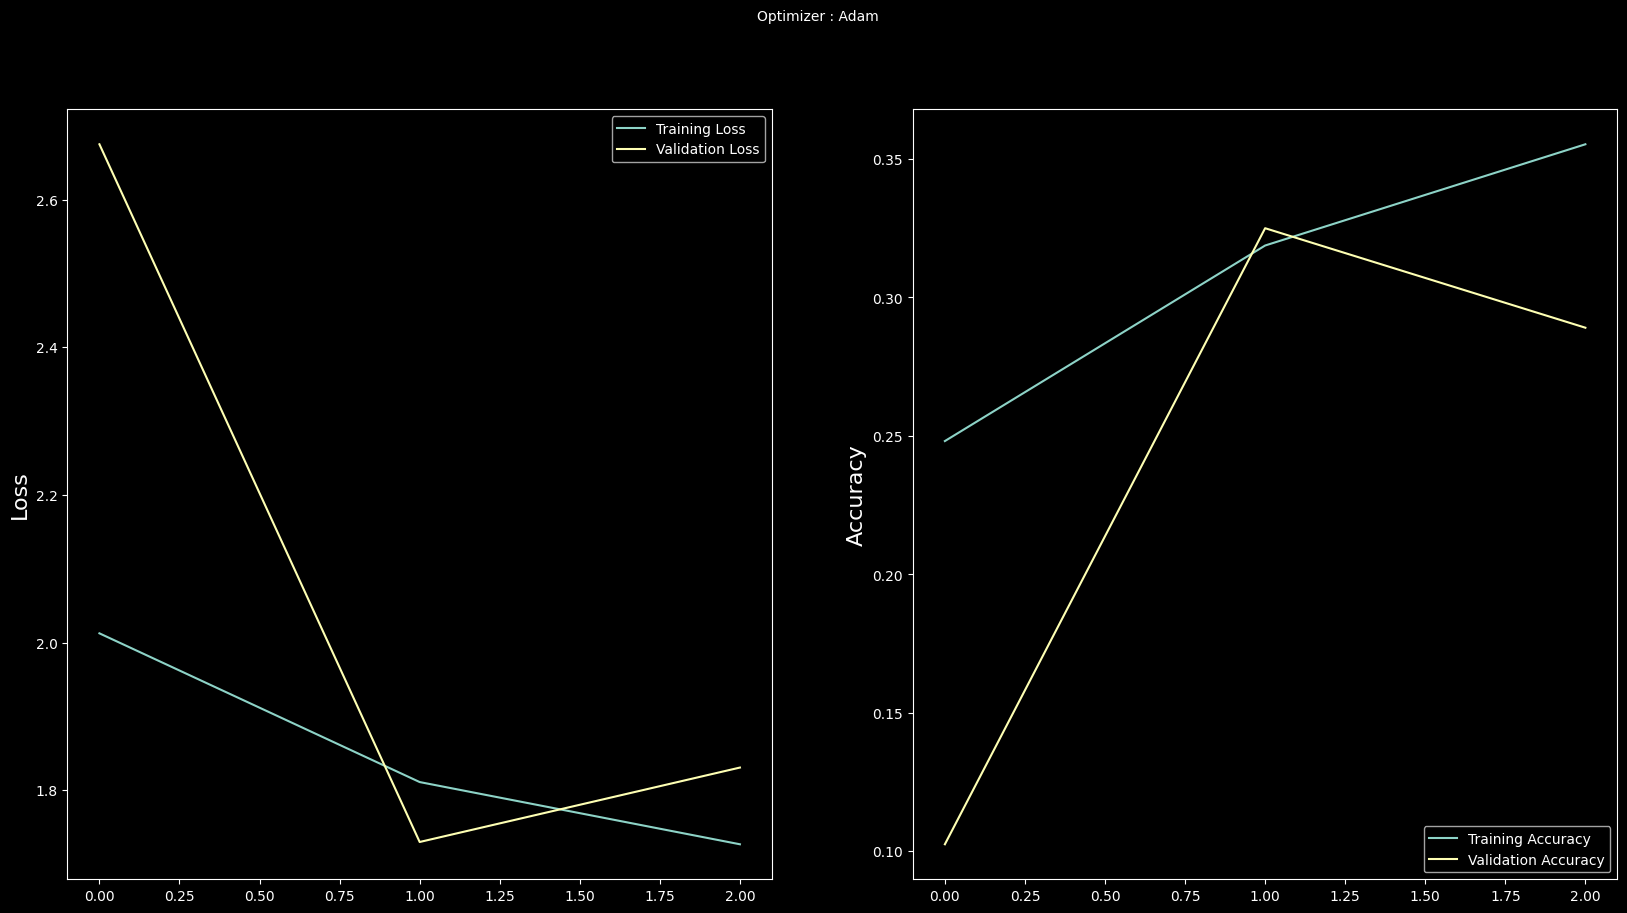

In [16]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()